# Inspect Datasets 

In [1]:
import os
import sys
print(sys.executable, sys.version)
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import trimesh

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf 

from glob import glob
from os.path import join, abspath
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

# for local import 
sys.path.append(abspath(join('..', '..')))

from main.config import Config
from main.dataset import Dataset
from main.smpl import Smpl
from main.model import ExceptionHandlingIterator

from trimesh_renderer import TrimeshRenderer
from vis_util import draw_2d_on_image, show_3d_pose, show_2d_pose

/home/mmc-user/.virtualenvs/hmr2-notebook/bin/python3 3.6.8 (default, Oct  7 2019, 12:59:55) 
[GCC 8.3.0]


In [2]:
class DastasetConfig(Config):
    DATA_DIR = join('/', 'data', 'ssd1', 'russales', 'tfrecords')    
    LOG_DIR = join('/', 'data', 'ssd1', 'russales', 'logs_notebook')

    DATASETS = ['lsp', 'lsp_ext', 'mpii', 'coco', 'mpii_3d', 'h36m', 'total_cap']
    SMPL_DATASETS = ['cmu', 'joint_lim']
    INITIALIZE_CUSTOM_REGRESSOR = False
    
# class Config is implemented as singleton, inizialize subclass first!
config = DastasetConfig()

In [3]:
tf_record_dirs = [join(config.DATA_DIR, dataset, '*_train.tfrecord') for dataset in config.DATASETS]
tf_records = [tf_record for tf_records in sorted([glob(f) for f in tf_record_dirs]) for tf_record in tf_records]

### visualize 2d keypoint data

In [4]:
# Place tensors on the CPU
with tf.device('/CPU:0'):
    dataset = Dataset()
    ds_train = dataset.get_train()
    ds_smpl = dataset.get_smpl()
    ds_val = dataset.get_val()

initialize train dataset...
Done (t=1.614121437072754)

initialize smpl dataset...
Done (t=0.16407012939453125)



In [5]:
def show_image(image, kp2d, vis):
    image = draw_2d_on_image(image, kp2d, vis=vis)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

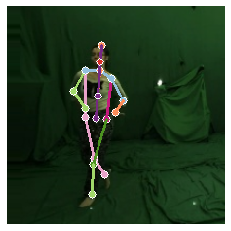

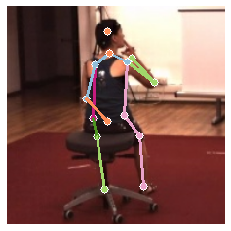

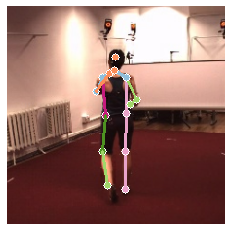

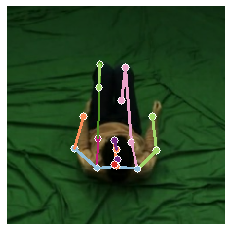

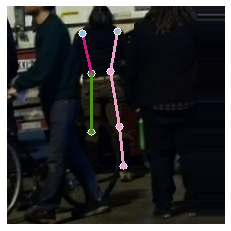

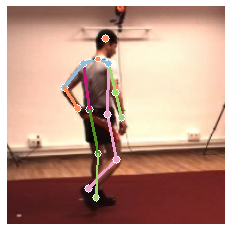

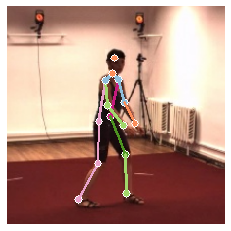

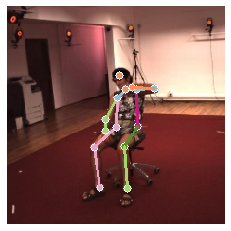

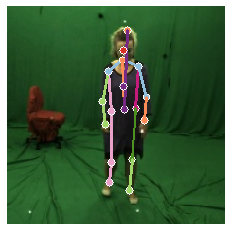

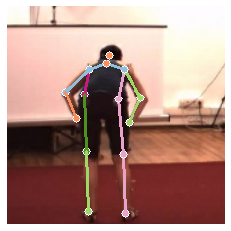

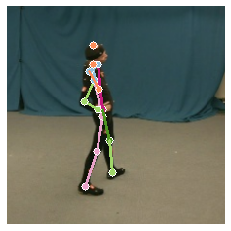

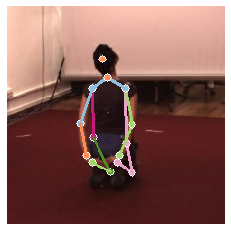

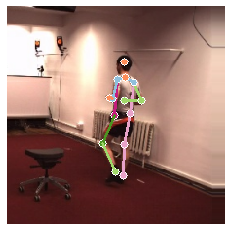

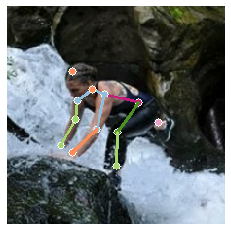

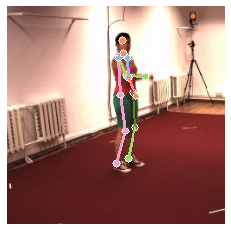

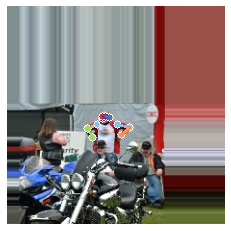

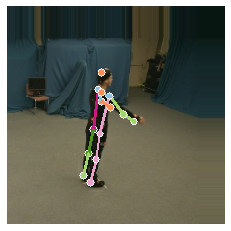

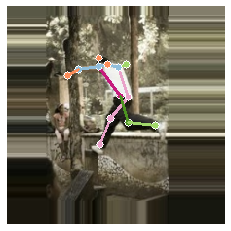

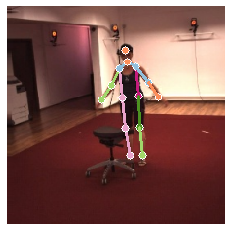

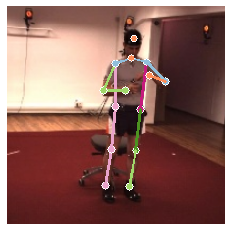

In [6]:
i, break_at = 0, 20
train_iter = ExceptionHandlingIterator(ds_train)
for images, kp2d, kp3d, has3d in train_iter:
    if i == break_at:
        break
        
    kp2d = kp2d[0].numpy()
    image = images[0].numpy()
    show_image(image, kp2d[:, :2], kp2d[:, 2])
    i += 1

### visualize 3D keypoint data

In [7]:
# Visualize random samples
import matplotlib.gridspec as gridspec
%matplotlib notebook

num_samples = 3

fig = plt.figure(figsize=(9.6, 5.4))
gs = gridspec.GridSpec(num_samples, 3) 
gs.update(wspace=-0.00, hspace=0.05)
plt.axis('off')

train_iter = ds_train.take(num_samples)

i, subplot_idx  = 0, 1
for images, kp2d, kp3d, has3d in train_iter:
    if i == break_at:
        break
    image = images[0].numpy()
    kp2d = kp2d[0].numpy()
    kp3d = kp3d[0].numpy()
    
    image = draw_2d_on_image(image, kp2d[:, :2], vis=kp2d[:, 2])
    ax0 = plt.subplot(gs[subplot_idx - 1])
    ax0.imshow(image)
    
    ax1 = plt.subplot(gs[subplot_idx], projection='3d')
    show_3d_pose(kp3d, ax1)
    
    ax2 = plt.subplot(gs[subplot_idx + 1])
    show_2d_pose(kp2d[:, :2], kp2d[:, 2], ax2, image.shape[:2])
    
    subplot_idx = subplot_idx + 3
    i += 1
    
plt.show()

<IPython.core.display.Javascript object>

### visualize SMPL/Mosh data

In [8]:
renderer = TrimeshRenderer()
smpl = Smpl()

In [10]:
meshes = []
for i, theta in enumerate(ds_smpl.take(5)):
    vertices, joints_3d, rotations = smpl(theta)
    mesh = renderer.mesh(vertices[0])
    mesh.apply_translation([i*1,0,0])
    transform = trimesh.transformations.rotation_matrix(np.deg2rad(90), [1, 0, 0], mesh.centroid)
    mesh.apply_transform(transform)
    mesh.visual.vertex_colors = [245,245,245, 255] # or trimesh.visual.random_color()
    
    meshes.append(mesh)

trimesh.Scene(meshes).show()

/home/mmc-user/.virtualenvs/hmr2-notebook/lib/python3.6/site-packages/trimesh/scene/scene.py:186: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if name in self.graph.nodes:
